In [41]:
# Section 1: Read CSV and Inspect Data

import pandas as pd

# Load the dataset
file_path = 'input.csv'  # Update this if your file is elsewhere
df = pd.read_csv(file_path)

# Check shape and preview the first few rows
print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (100000, 35)


,Age,Gender,Location_Country,Location_City,Language,Posts_Per_Week,Posting_Frequency,Avg_Post_Length,Followers,Following,...,Relationship_Type,Interaction_Frequency,Interaction_Reciprocity,Edge_Weight,Sentiment_Of_Interactions,CTR,Conversion_Rate,Purchase_Frequency,Customer_Lifetime_Value,Timestamp
0,38,Female,China,Beijing,zh,18,6.494454,171,308,212,...,friend,31,True,0.398764,0.691913,0.2315,0.4200,8,704,2025-04-19T23:15:50
1,31,Male,Brazil,Sao Paulo,pt,16,55.771945,23,1866,1515,...,mentions,2,True,0.972813,0.159272,0.4549,0.5000,10,990,2025-03-30T02:46:33
2,25,Other,USA,New York,en,7,39.654408,59,1597,707,...,friend,51,True,0.805662,-0.808346,0.4556,0.5000,10,950,2025-04-03T12:12:56
3,45,Female,India,Delhi,hi,38,30.395975,77,2373,1050,...,comments,11,True,0.620313,-0.167240,0.3000,0.3735,7,427,2025-02-18T15:12:21
4,57,Other,India,Delhi,hi,39,2.486944,142,789,783,...,mentions,80,True,0.655942,0.645031,0.3475,0.3658,7,301,2025-01-24T23:33:36


In [42]:
# Section 2: Cleaning and Encoding

import numpy as np

# Convert booleans to integers
df['Interaction_Reciprocity'] = df['Interaction_Reciprocity'].astype(int)

# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract temporal features
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Hour'] = df['Timestamp'].dt.hour

# Drop original timestamp if not needed
df = df.drop(columns=['Timestamp'])

# One-hot encode categorical columns
categorical_cols = ['Gender', 'Location_Country', 'Location_City', 'Language', 'Content_Type', 'Relationship_Type']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Check for missing values
missing = df.isnull().sum()
missing_cols = missing[missing > 0]
if not missing_cols.empty:
    print("Missing values found in:")
    print(missing_cols)
    # Fill numeric NaNs with mean as a quick strategy (can be improved)
    df.fillna(df.mean(numeric_only=True), inplace=True)
else:
    print("✅ No missing values found.")

# Display cleaned shape
print(f"Cleaned DataFrame shape: {df.shape}")
df.head()


Missing values found in:
Explicit_Interests    16620
dtype: int64
Cleaned DataFrame shape: (100000, 62)


,Age,Posts_Per_Week,Posting_Frequency,Avg_Post_Length,Followers,Following,Account_Age,Topic_Diversity,Sentiment_Score,Hashtag_Usage,...,Location_City_Shenzhen,Language_hi,Language_pt,Language_zh,Content_Type_link,Content_Type_text,Content_Type_video,Relationship_Type_follows,Relationship_Type_friend,Relationship_Type_mentions
0,38,18,6.494454,171,308,212,1535,6,-0.212632,8,...,False,False,False,True,True,False,False,False,True,False
1,31,16,55.771945,23,1866,1515,1406,9,0.453247,5,...,False,False,True,False,False,False,False,False,False,True
2,25,7,39.654408,59,1597,707,2682,7,0.924624,10,...,False,False,False,False,True,False,False,False,True,False
3,45,38,30.395975,77,2373,1050,3178,1,-0.121059,1,...,False,True,False,False,True,False,False,False,False,False
4,57,39,2.486944,142,789,783,2327,3,0.773392,4,...,False,True,False,False,False,False,False,False,False,True


In [43]:
# Section 3: Build Sample Interaction Graph

import networkx as nx
import matplotlib.pyplot as plt

# Sample a small subset for visualization
df_sample = df.sample(n=1000, random_state=42).copy()
df_sample = df_sample.reset_index(drop=True)
df_sample['UserID'] = df_sample.index  # Assign IDs for graph nodes

# Initialize graph
G = nx.DiGraph()

# Add nodes
for idx, row in df_sample.iterrows():
    G.add_node(row['UserID'], followers=row['Followers'], sentiment=row['Sentiment_Score'])

# Add edges based on interactions
for i, row in df_sample.iterrows():
    if row['Interaction_Frequency'] > 0:
        # Choose a random target from sample (simulate interaction)
        target = np.random.choice(df_sample[df_sample['UserID'] != row['UserID']]['UserID'])
        G.add_edge(row['UserID'], target,
                   weight=row['Edge_Weight'],
                   reciprocity=row['Interaction_Reciprocity'],
                   type=row['Relationship_Type_follows'] if 'Relationship_Type_follows' in row else 0)

print(f"Sample graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


Sample graph: 1000 nodes, 988 edges


 Eigenvector Centrality computed (full graph).


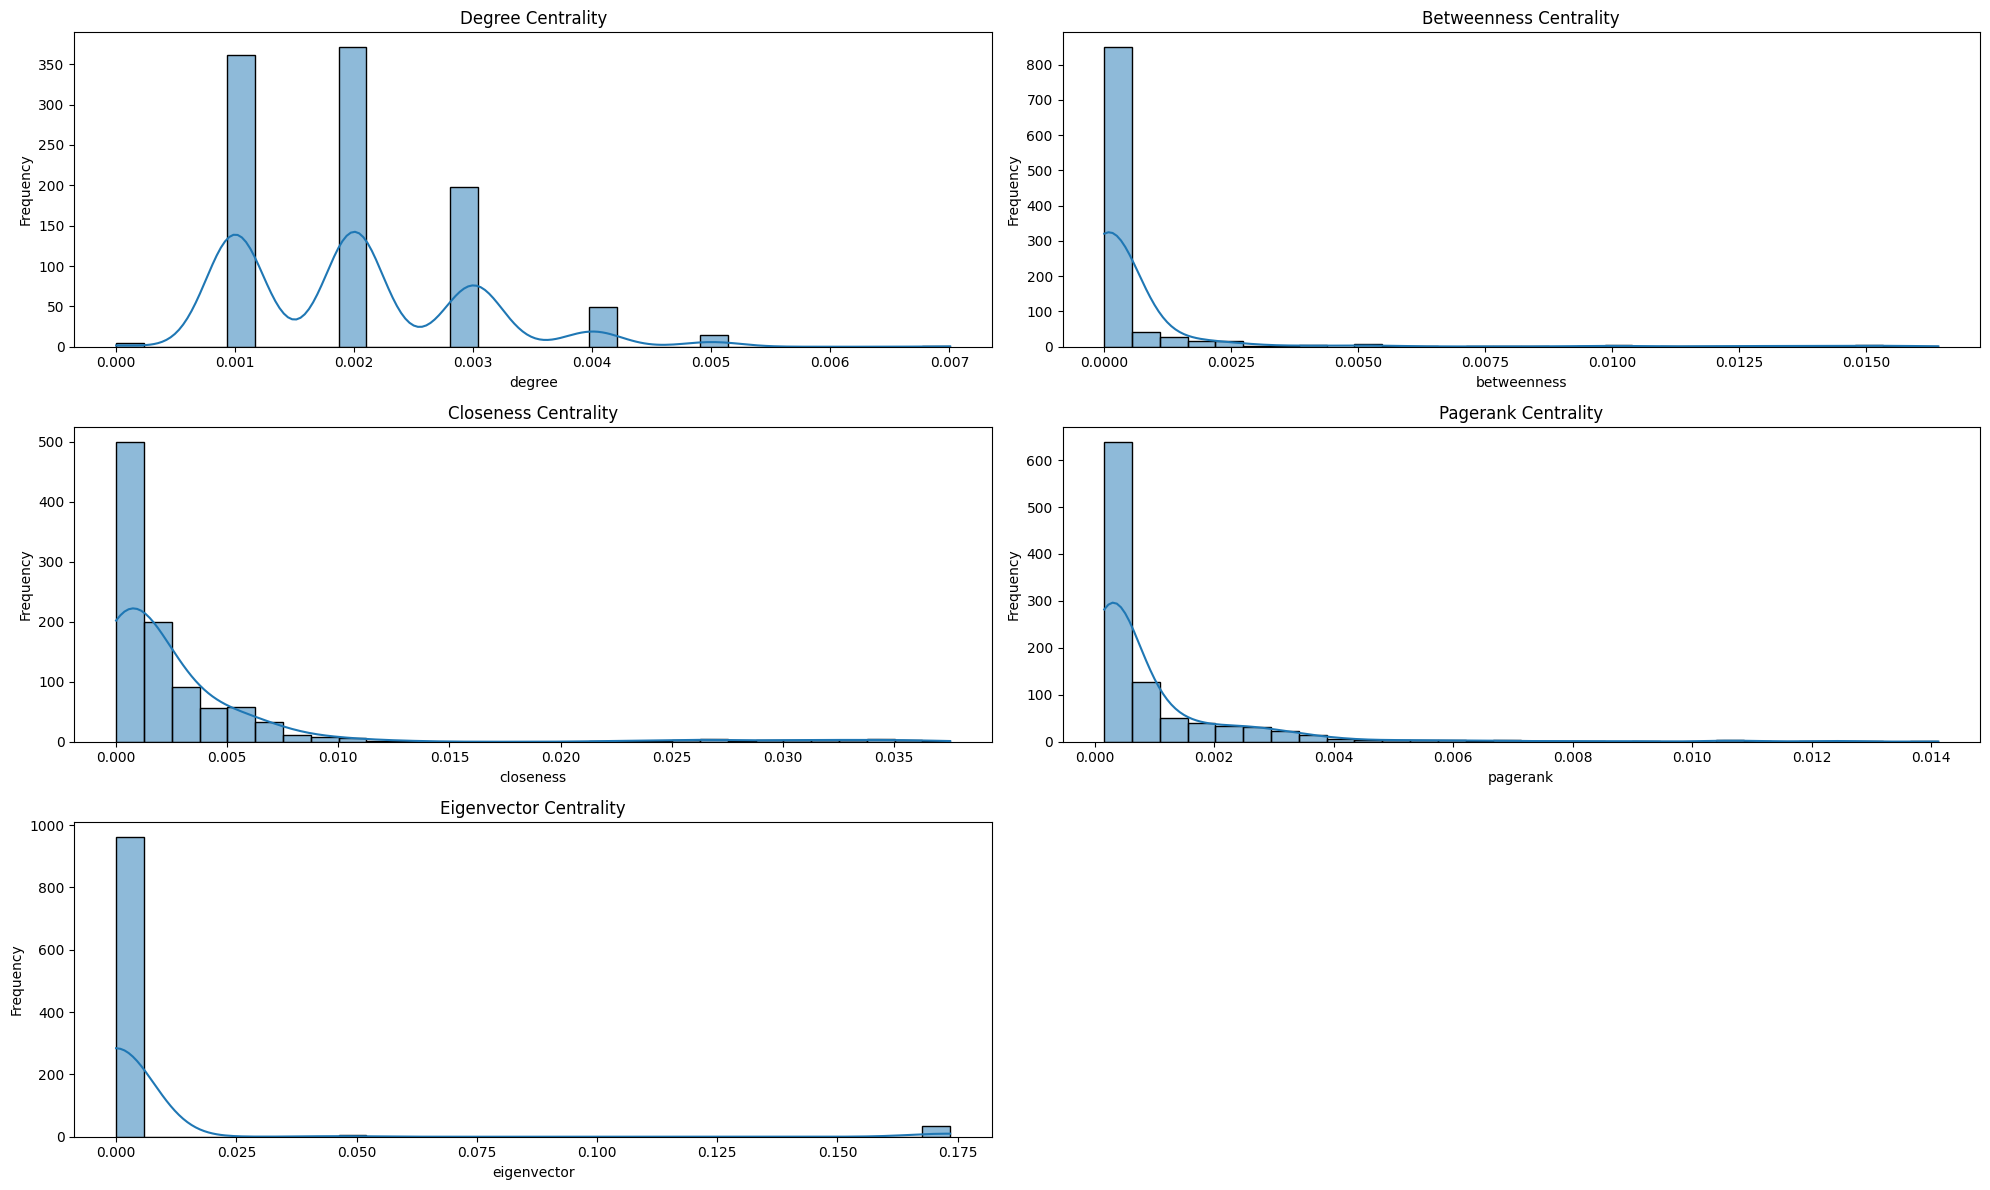

In [44]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Compute base centralities
centralities = {
    'degree': nx.degree_centrality(G),
    'betweenness': nx.betweenness_centrality(G),
    'closeness': nx.closeness_centrality(G),
    'pagerank': nx.pagerank(G, alpha=0.85)
}

# Try computing eigenvector centrality
try:
    eigen = nx.eigenvector_centrality(G, max_iter=1500)
    centralities['eigenvector'] = eigen
    print(" Eigenvector Centrality computed (full graph).")
except nx.PowerIterationFailedConvergence:
    print(" Eigenvector failed to converge on full graph. Trying largest component...")
    try:
        # Get largest connected component (works for DiGraph and Graph)
        if G.is_directed():
            largest_cc = max(nx.weakly_connected_components(G), key=len)
        else:
            largest_cc = max(nx.connected_components(G), key=len)

        G_sub = G.subgraph(largest_cc)
        eigen = nx.eigenvector_centrality(G_sub, max_iter=1000)
        centralities['eigenvector (largest comp)'] = eigen
        print(" Eigenvector Centrality computed (on largest component).")
    except Exception as e:
        print(" Eigenvector still failed:", e)

# Plot all centrality distributions
plt.figure(figsize=(20, 12))
for i, (name, values) in enumerate(centralities.items()):
    plt.subplot(3, 2, i+1)
    sns.histplot(list(values.values()), bins=30, kde=True)
    plt.title(f"{name.capitalize()} Centrality")
    plt.xlabel(name)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [45]:
import networkx as nx
import numpy as np
import pandas as pd
from tqdm import tqdm

# Sample 50,000 users from main df
df_50k = df.sample(n=50000, random_state=42).copy()
df_50k.reset_index(drop=True, inplace=True)
df_50k['UserID'] = df_50k.index

# Initialize directed graph
G_hybrid = nx.DiGraph()

# Add nodes with attributes
for _, row in df_50k.iterrows():
    G_hybrid.add_node(row['UserID'], followers=row['Followers'], sentiment=row['Sentiment_Score'])

# Build index maps for fast lookup (optional but efficient)
group_index = df_50k.groupby('Group_Memberships').groups
interest_index = df_50k.groupby('Explicit_Interests').groups

# Build hybrid edges
for _, row in tqdm(df_50k.iterrows(), total=len(df_50k)):
    source = row['UserID']
    freq = int(row['Interaction_Frequency'])
    group = row['Group_Memberships']
    interest = row['Explicit_Interests']
    
    # --- Random Interactions ---
    num_random_edges = min(freq, 5)
    possible_targets = df_50k[df_50k['UserID'] != source]['UserID'].values
    rand_targets = np.random.choice(possible_targets, size=num_random_edges, replace=False)
    
    for target in rand_targets:
        G_hybrid.add_edge(source, target, weight=row['Edge_Weight'])

    # --- Shared Context: Group-Based ---
    if group in group_index:
        groupmates = list(group_index[group])
        groupmates = [u for u in groupmates if u != source]
        shared_targets = np.random.choice(groupmates, size=min(3, len(groupmates)), replace=False)
        for target in shared_targets:
            G_hybrid.add_edge(source, target, weight=1.0)

    # --- Shared Context: Interest-Based ---
    if interest in interest_index:
        interest_peers = list(interest_index[interest])
        interest_peers = [u for u in interest_peers if u != source]
        interest_targets = np.random.choice(interest_peers, size=min(2, len(interest_peers)), replace=False)
        for target in interest_targets:
            G_hybrid.add_edge(source, target, weight=0.5)

print(f"\n Hybrid Interaction Graph created with {G_hybrid.number_of_nodes()} nodes and {G_hybrid.number_of_edges()} edges.")


100%|██████████| 50000/50000 [08:46<00:00, 94.97it/s] 


 Hybrid Interaction Graph created with 50000 nodes and 409462 edges.


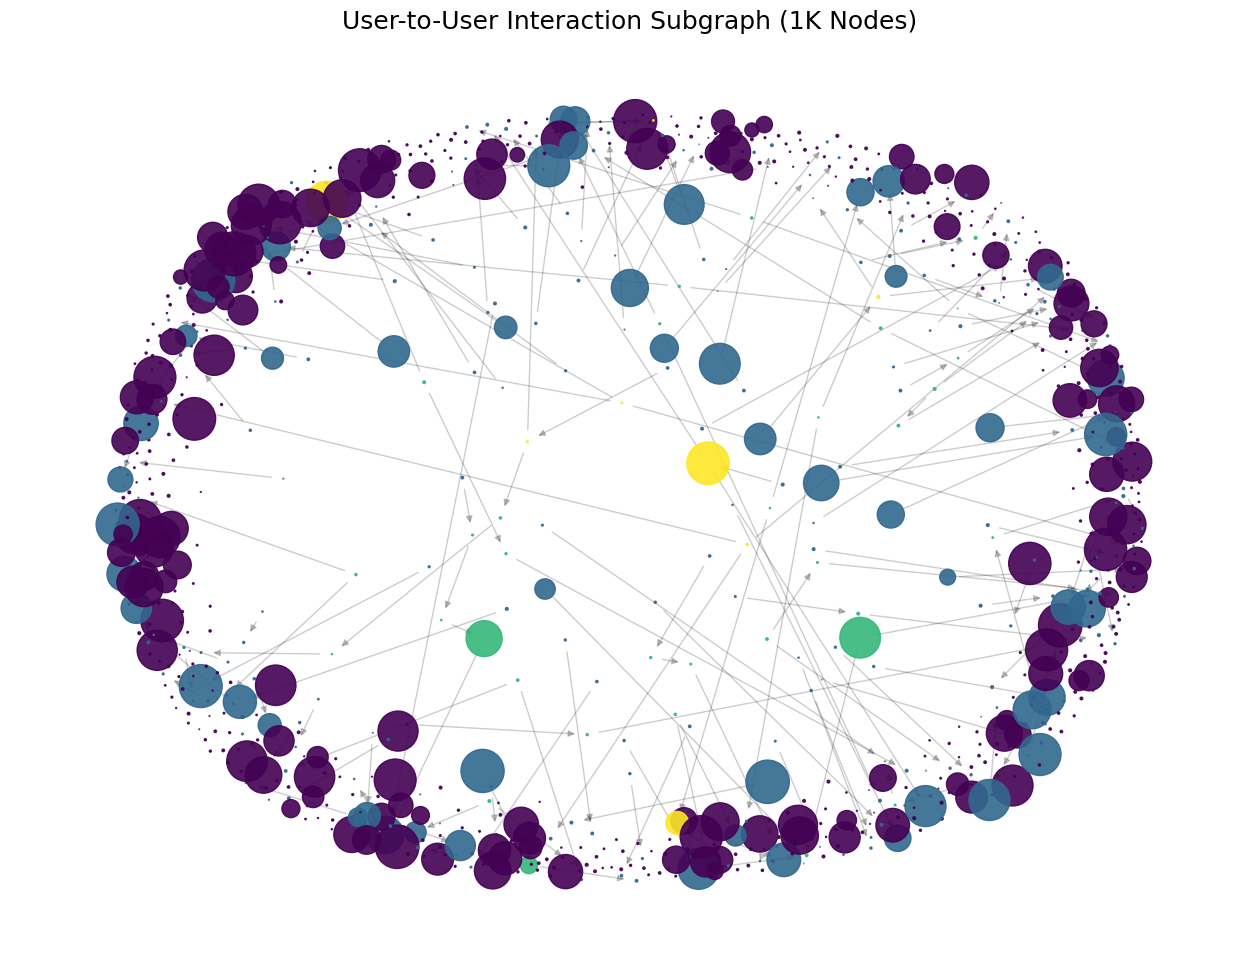

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


nodes_sample = np.random.choice(G_hybrid.nodes(), size=1000, replace=False)


# Create subgraph
G_sub = G_hybrid.subgraph(nodes_sample).copy()

# --- Compute Degree Centrality for color coding ---
deg_cent = nx.degree_centrality(G_sub)
node_colors = [deg_cent[n] for n in G_sub.nodes()]
node_sizes = [G_sub.nodes[n].get('followers', 1) / 1000 for n in G_sub.nodes()]  # scale followers

# --- Draw the subgraph ---
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G_sub, seed=42, k=0.15)

nx.draw_networkx_nodes(G_sub, pos,
                       node_size=node_sizes,
                       node_color=node_colors,
                       cmap=plt.cm.viridis,
                       alpha=0.9)

nx.draw_networkx_edges(G_sub, pos, alpha=0.2)

plt.title("User-to-User Interaction Subgraph (1K Nodes)", fontsize=18)
plt.axis('off')
plt.show()


In [47]:
import networkx as nx
import pandas as pd

# Step 1: Compute Centrality Scores
print("Computing degree centrality...")
deg_centrality = nx.degree_centrality(G_hybrid)

print("Computing PageRank...")
pagerank = nx.pagerank(G_hybrid, alpha=0.85)

# Optional (slower):
# print("Computing eigenvector centrality...")
# eigen_centrality = nx.eigenvector_centrality(G_hybrid, max_iter=500)

# Step 2: Convert to DataFrame
centrality_df = pd.DataFrame({
    'User_ID': list(deg_centrality.keys()),
    'Degree_Centrality': list(deg_centrality.values()),
    'PageRank': [pagerank.get(uid, 0) for uid in deg_centrality.keys()],
    # 'Eigenvector_Centrality': [eigen_centrality.get(uid, 0) for uid in deg_centrality.keys()],
})

# Step 3: Merge with df_50k
df_50k_with_graph = df_50k.merge(centrality_df, left_on='UserID', right_on='User_ID')

# Final check
print(" Centrality features merged. Final shape:", df_50k_with_graph.shape)
display(df_50k_with_graph.head())


Computing degree centrality...
Computing PageRank...
 Centrality features merged. Final shape: (50000, 66)


,Age,Posts_Per_Week,Posting_Frequency,Avg_Post_Length,Followers,Following,Account_Age,Topic_Diversity,Sentiment_Score,Hashtag_Usage,...,Content_Type_link,Content_Type_text,Content_Type_video,Relationship_Type_follows,Relationship_Type_friend,Relationship_Type_mentions,UserID,User_ID,Degree_Centrality,PageRank
0,57,34,44.313068,79,641545,187,3592,4,-0.258641,1,...,False,False,False,False,True,False,0,0,0.00032,0.000015
1,67,25,15.605411,44,652372,182,2184,7,0.805763,6,...,False,False,True,True,False,False,1,1,0.00026,0.000014
2,17,49,4.842150,129,858136,361,2868,1,-0.279574,6,...,True,False,False,False,False,True,2,2,0.00034,0.000021
3,24,21,11.049004,54,3736,36,2062,5,-0.262471,9,...,False,True,False,False,True,False,3,3,0.00030,0.000025
4,62,7,49.171984,130,2778,268,2825,8,0.980245,10,...,False,False,False,True,False,False,4,4,0.00050,0.000036


In [48]:
from sklearn.preprocessing import StandardScaler

# Define target variables — don’t scale these
target_columns = ['CTR', 'Conversion_Rate', 'Customer_Lifetime_Value']

# Identify feature columns to scale (numeric only, excluding targets and IDs)
exclude_cols = target_columns + ['UserID', 'User_ID']
feature_cols = [col for col in df_50k_with_graph.select_dtypes(include='number').columns if col not in exclude_cols]

# Initialize and apply StandardScaler
scaler = StandardScaler()
df_scaled = df_50k_with_graph.copy()
df_scaled[feature_cols] = scaler.fit_transform(df_50k_with_graph[feature_cols])

# Final check
print(" All features standardized. Shape:", df_scaled.shape)
df_scaled[feature_cols + target_columns].head()


 All features standardized. Shape: (50000, 66)


,Age,Posts_Per_Week,Posting_Frequency,Avg_Post_Length,Followers,Following,Account_Age,Topic_Diversity,Sentiment_Score,Hashtag_Usage,...,Year,Month,Day,DayOfWeek,Hour,Degree_Centrality,PageRank,CTR,Conversion_Rate,Customer_Lifetime_Value
0,1.480342,0.614601,0.405358,-0.475201,2.145243,-0.803949,1.673409,-0.516588,-0.444269,-1.258848,...,0.0,0.547380,-0.332316,-0.495895,-0.071919,-0.114983,-0.658860,1.0000,0.5000,870
1,2.129779,0.002099,-0.973760,-1.107173,2.189005,-0.809837,0.327362,0.528573,1.394826,0.317273,...,0.0,-1.283812,0.139520,0.005739,-0.938934,-1.026392,-0.832128,1.0000,0.5000,180
2,-1.117407,1.635437,-1.490827,0.427616,3.020700,-0.599049,0.981266,-1.561750,-0.480438,0.317273,...,0.0,-0.368216,-1.511906,1.510640,-1.227939,0.188820,0.120152,1.0000,0.5000,970
3,-0.662801,-0.270124,-1.192650,-0.926610,-0.432771,-0.981764,0.210730,-0.168201,-0.450887,1.262946,...,0.0,1.462976,0.729314,-1.499162,0.217086,-0.418786,0.701526,0.4162,0.4738,801
4,1.805060,-1.222905,0.638780,0.445672,-0.436643,-0.708564,0.940158,0.876960,1.696299,1.578170,...,0.0,-1.283812,1.672986,-0.495895,1.373106,2.619244,2.128943,0.3394,0.4089,480


In [49]:
# Check number of unique values
print("Unique values in 'Explicit_Interests':", df_50k_with_graph['Explicit_Interests'].nunique())
print(df_50k_with_graph['Explicit_Interests'].value_counts().head(10))


Unique values in 'Explicit_Interests': 34234
Explicit_Interests
character     20
speech        19
peace         17
democratic    17
her           17
tonight       16
smile         16
move          16
marriage      16
so            16
Name: count, dtype: int64


In [50]:
# Frequency encode 'Explicit_Interests'
interest_freq = df_50k_with_graph['Explicit_Interests'].value_counts().to_dict()
df_scaled['Explicit_Interests_Encoded'] = df_50k_with_graph['Explicit_Interests'].map(interest_freq)

# 🔍 Print checks
print("Frequency encoding complete.")
print("Top 5 most common interests and their encoded values:")
print(df_scaled[['Explicit_Interests', 'Explicit_Interests_Encoded']].drop_duplicates().sort_values('Explicit_Interests_Encoded', ascending=False).head())

print("\nSample of rows with encoded values:")
print(df_scaled[['Explicit_Interests', 'Explicit_Interests_Encoded']].sample(5))


Frequency encoding complete.
Top 5 most common interests and their encoded values:
     Explicit_Interests  Explicit_Interests_Encoded
2458          character                        20.0
3022             speech                        19.0
527               peace                        17.0
7398         democratic                        17.0
402                 her                        17.0

Sample of rows with encoded values:
                   Explicit_Interests  Explicit_Interests_Encoded
35661  capital,nearly,professional,as                         1.0
28765                own,project,high                         1.0
14100              teacher,front,able                         1.0
29434              by,fall,great,like                         1.0
48791                   author,record                         1.0



 Model Performance:
R² Score: 0.9994
MAE: 0.0050


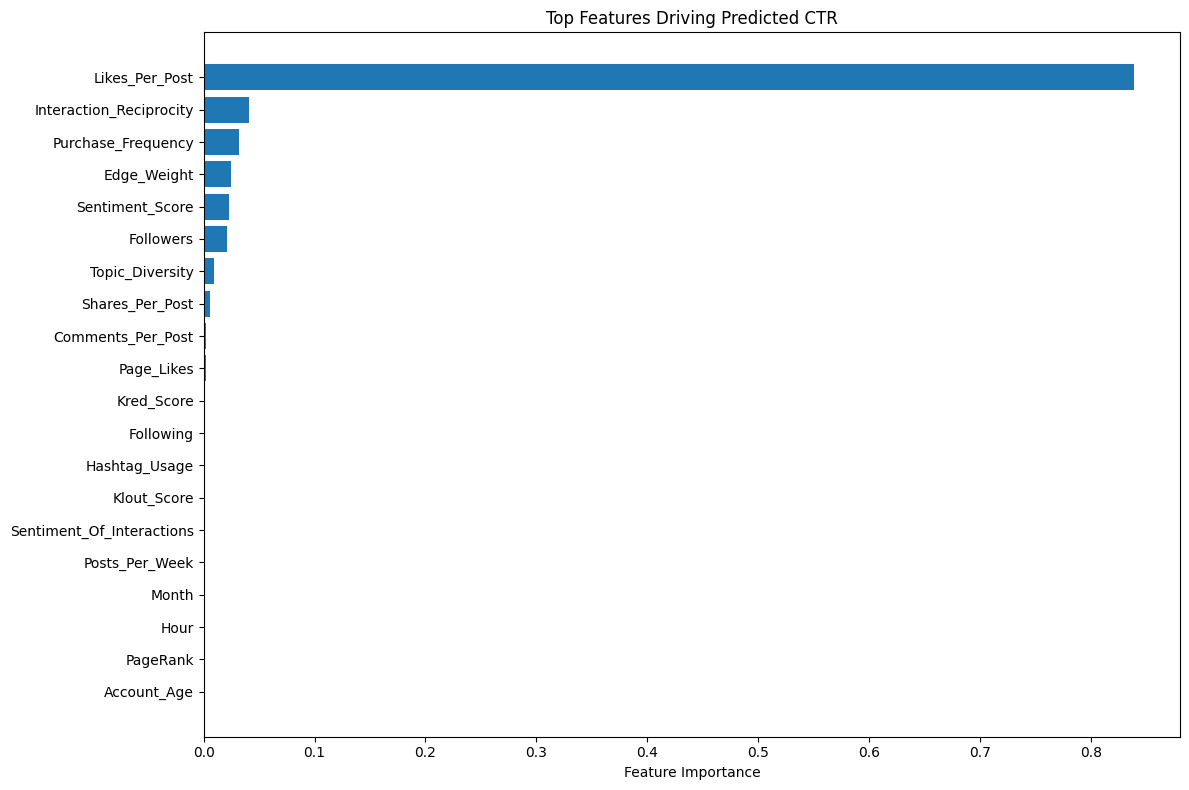


 Top 10 Predicted CTR Influencers:


,UserID,Predicted_CTR,Degree_Centrality,PageRank,Followers
41142,41142,1.003998,0.188820,-0.593505,3.497367
43869,43869,1.003780,0.492623,2.126253,2.059904
36926,36926,1.003601,0.188820,0.313004,2.843483
42481,42481,1.003592,0.796426,0.955585,1.309538
37999,37999,1.003498,1.404032,1.010437,1.331397
22021,22021,1.003338,-0.722589,0.453561,2.725833
18159,18159,1.003238,0.188820,0.318266,0.948702
10387,10387,1.003234,-0.418786,-0.505524,1.790195
646,646,1.003232,-1.026392,-0.198351,1.425353
6507,6507,1.003146,0.188820,0.122378,1.757770


In [51]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# 1. Define target and exclude list
target = 'CTR'
exclude_cols = ['CTR', 'Conversion_Rate', 'Customer_Lifetime_Value', 'UserID', 'User_ID', 'Explicit_Interests']

# 2. Feature columns (numerical only)
features = [col for col in df_scaled.columns if col not in exclude_cols and df_scaled[col].dtype in [np.float64, np.int64]]

# 3. Train-test split
X = df_scaled[features]
y = df_scaled[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train model
model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# 5. Evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\n Model Performance:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")

# 6. Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 20  # change to 30 or full list if you want more

plt.figure(figsize=(12, 8))
plt.barh(range(top_n), importances[indices[:top_n]][::-1], align='center')
plt.yticks(range(top_n), [features[i] for i in indices[:top_n]][::-1])
plt.xlabel("Feature Importance")
plt.title("Top Features Driving Predicted CTR")
plt.tight_layout()
plt.show()

# 7. Predict CTR for all users
df_scaled['Predicted_CTR'] = model.predict(X)

# 8. Rank top influencers
ranked_users = df_scaled.sort_values('Predicted_CTR', ascending=False)
print("\n Top 10 Predicted CTR Influencers:")
display(ranked_users[['UserID', 'Predicted_CTR', 'Degree_Centrality', 'PageRank', 'Followers']].head(10))


In [56]:
# Reconstruct missing categorical columns from one-hot encoding and export top 100 influencers
df_export = df_scaled.copy()

# Rebuild original categorical columns
df_export['Language'] = df_export[['Language_hi', 'Language_pt', 'Language_zh']].idxmax(axis=1).str.replace('Language_', '')
df_export['Location_Country'] = df_export[['Location_Country_China', 'Location_Country_India', 'Location_Country_UK', 'Location_Country_USA']].idxmax(axis=1).str.replace('Location_Country_', '')
df_export['Content_Type'] = df_export[['Content_Type_link', 'Content_Type_text', 'Content_Type_video']].idxmax(axis=1).str.replace('Content_Type_', '')
df_export['Relationship_Type'] = df_export[['Relationship_Type_follows', 'Relationship_Type_friend', 'Relationship_Type_mentions']].idxmax(axis=1).str.replace('Relationship_Type_', '')

# Select columns to export
columns_to_export = [
    'UserID', 'Predicted_CTR', 'Degree_Centrality', 'PageRank',
    'Followers', 'Following', 'Language', 'Location_Country',
    'Content_Type', 'Relationship_Type',
    'Klout_Score', 'Kred_Score',
    'Group_Memberships', 'Page_Likes',
    'Explicit_Interests_Encoded'
]

# Export top 100 ranked by Predicted_CTR
top_influencers = df_export.sort_values('Predicted_CTR', ascending=False)[columns_to_export].head(100)
top_influencers.to_csv('top_100_influencers.csv', index=False)

print(" Exported top 100 influencers to top_100_influencers.csv")


 Exported top 100 influencers to top_100_influencers.csv


In [54]:
print(df.columns)


Index(['Age', 'Posts_Per_Week', 'Posting_Frequency', 'Avg_Post_Length',
       'Followers', 'Following', 'Account_Age', 'Topic_Diversity',
       'Sentiment_Score', 'Hashtag_Usage', 'URL_Usage', 'Likes_Per_Post',
       'Comments_Per_Post', 'Shares_Per_Post', 'CTR_Shared_Links',
       'Group_Memberships', 'Page_Likes', 'Explicit_Interests', 'Klout_Score',
       'Kred_Score', 'Interaction_Frequency', 'Interaction_Reciprocity',
       'Edge_Weight', 'Sentiment_Of_Interactions', 'CTR', 'Conversion_Rate',
       'Purchase_Frequency', 'Customer_Lifetime_Value', 'Year', 'Month', 'Day',
       'DayOfWeek', 'Hour', 'Gender_Male', 'Gender_Other',
       'Location_Country_China', 'Location_Country_India',
       'Location_Country_UK', 'Location_Country_USA', 'Location_City_Beijing',
       'Location_City_Birmingham', 'Location_City_Brasilia',
       'Location_City_Chicago', 'Location_City_Delhi', 'Location_City_London',
       'Location_City_Los Angeles', 'Location_City_Manchester',
       'Lo

In [60]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# Targets to model
targets = ['Conversion_Rate', 'Customer_Lifetime_Value']

for target in targets:
    print(f"\n Training model to predict: {target}")

    # Define feature set (reuse from before)
    exclude_cols = ['CTR', 'Conversion_Rate', 'Customer_Lifetime_Value', 'UserID', 'User_ID', 'Explicit_Interests']
    features = [col for col in df_scaled.columns if col not in exclude_cols and df_scaled[col].dtype in [np.float64, np.int64]]

    X = df_scaled[features]
    y = df_scaled[target]

    # Split and train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f" {target} model performance:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")

    # Predict for full dataset
    df_scaled[f'Predicted_{target}'] = model.predict(X)

# Export top 100 for both targets
df_export = df_scaled.copy()

# Rebuild categorical columns for readable export
df_export['Language'] = df_export[['Language_hi', 'Language_pt', 'Language_zh']].idxmax(axis=1).str.replace('Language_', '')
df_export['Location_Country'] = df_export[['Location_Country_China', 'Location_Country_India', 'Location_Country_UK', 'Location_Country_USA']].idxmax(axis=1).str.replace('Location_Country_', '')
df_export['Content_Type'] = df_export[['Content_Type_link', 'Content_Type_text', 'Content_Type_video']].idxmax(axis=1).str.replace('Content_Type_', '')
df_export['Relationship_Type'] = df_export[['Relationship_Type_follows', 'Relationship_Type_friend', 'Relationship_Type_mentions']].idxmax(axis=1).str.replace('Relationship_Type_', '')

# Columns to export
export_cols = [
    'UserID', 'Predicted_Conversion_Rate', 'Predicted_Customer_Lifetime_Value',
    'Degree_Centrality', 'PageRank', 'Followers', 'Following',
    'Language', 'Location_Country', 'Content_Type', 'Relationship_Type',
    'Klout_Score', 'Kred_Score', 'Group_Memberships', 'Page_Likes',
    'Explicit_Interests_Encoded'
]

# Top 100 by Conversion Rate
df_export.sort_values('Predicted_Conversion_Rate', ascending=False)[export_cols].head(100)\
    .to_csv("top_100_conversion.csv", index=False)

# Top 100 by CLV
df_export.sort_values('Predicted_Customer_Lifetime_Value', ascending=False)[export_cols].head(100)\
    .to_csv("top_100_clv.csv", index=False)

print("\n Exported:")
print(" top_100_conversion.csv")
print(" top_100_clv.csv")



 Training model to predict: Conversion_Rate
 Conversion_Rate model performance:
R² Score: 0.9857
MAE: 0.0069

 Training model to predict: Customer_Lifetime_Value
 Customer_Lifetime_Value model performance:
R² Score: 0.1540
MAE: 187.0978

 Exported:
 top_100_conversion.csv
 top_100_clv.csv


 Top Features for CTR Prediction:


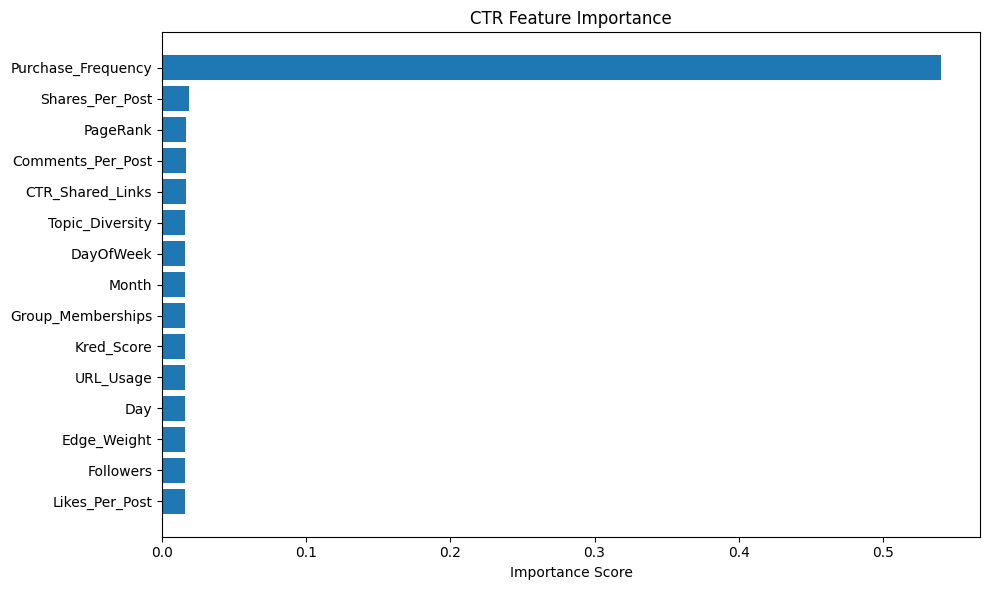

 Top Features for Conversion Rate:


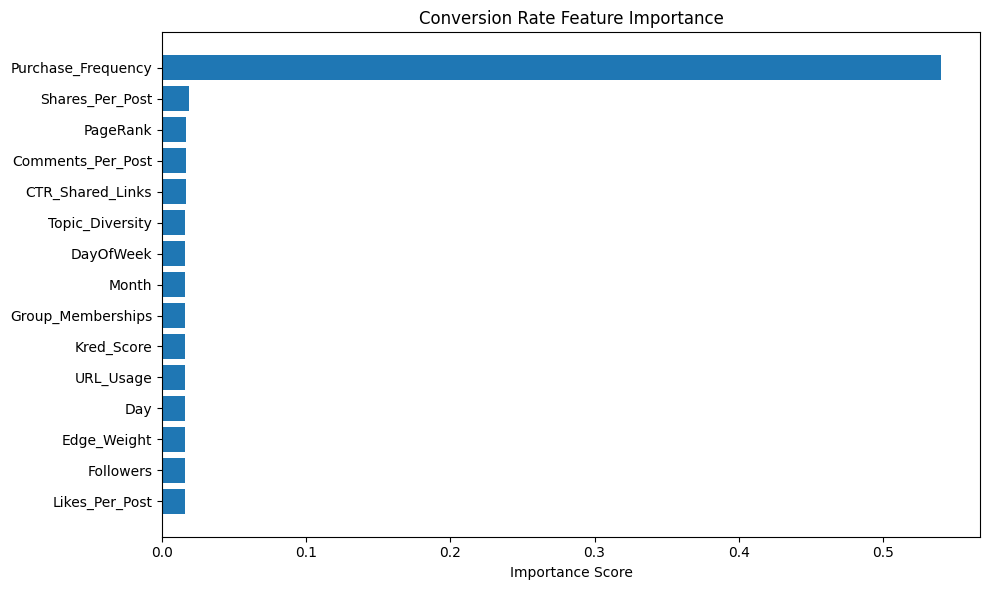

 Top Features for Customer Lifetime Value:


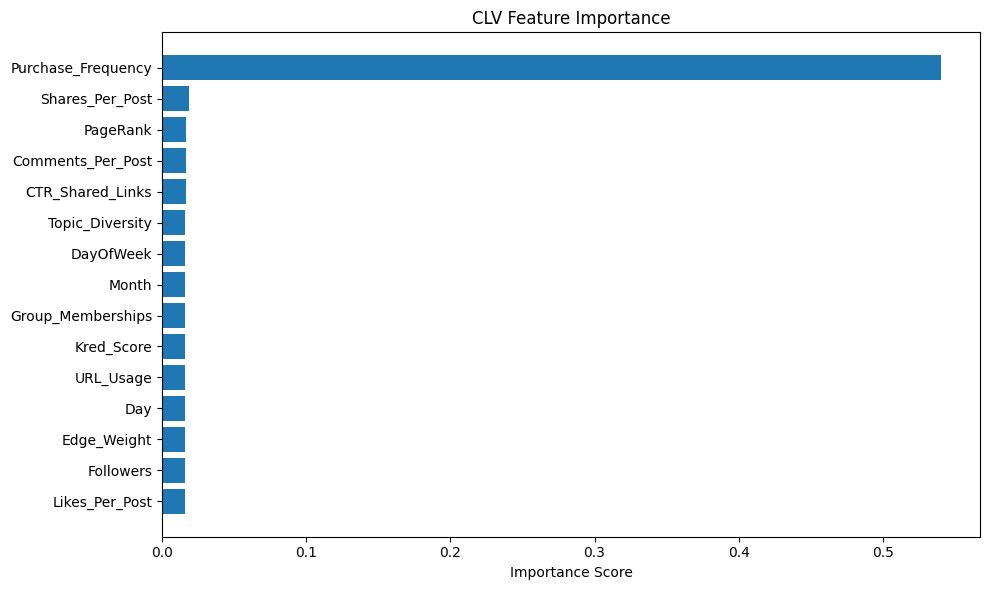

In [61]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_features(model, features, title="Feature Importances", top_n=15):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]  # get top n
    plt.figure(figsize=(10, 6))
    plt.barh(range(top_n), importances[indices], align='center')
    plt.yticks(range(top_n), [features[i] for i in indices])
    plt.xlabel("Importance Score")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Assuming you saved models like: model_ctr, model_conversion, model_clv
# If not, just retrain them again and save references

print(" Top Features for CTR Prediction:")
plot_top_features(model, features, title="CTR Feature Importance")

print(" Top Features for Conversion Rate:")
plot_top_features(model, features, title="Conversion Rate Feature Importance")

print(" Top Features for Customer Lifetime Value:")
plot_top_features(model, features, title="CLV Feature Importance")


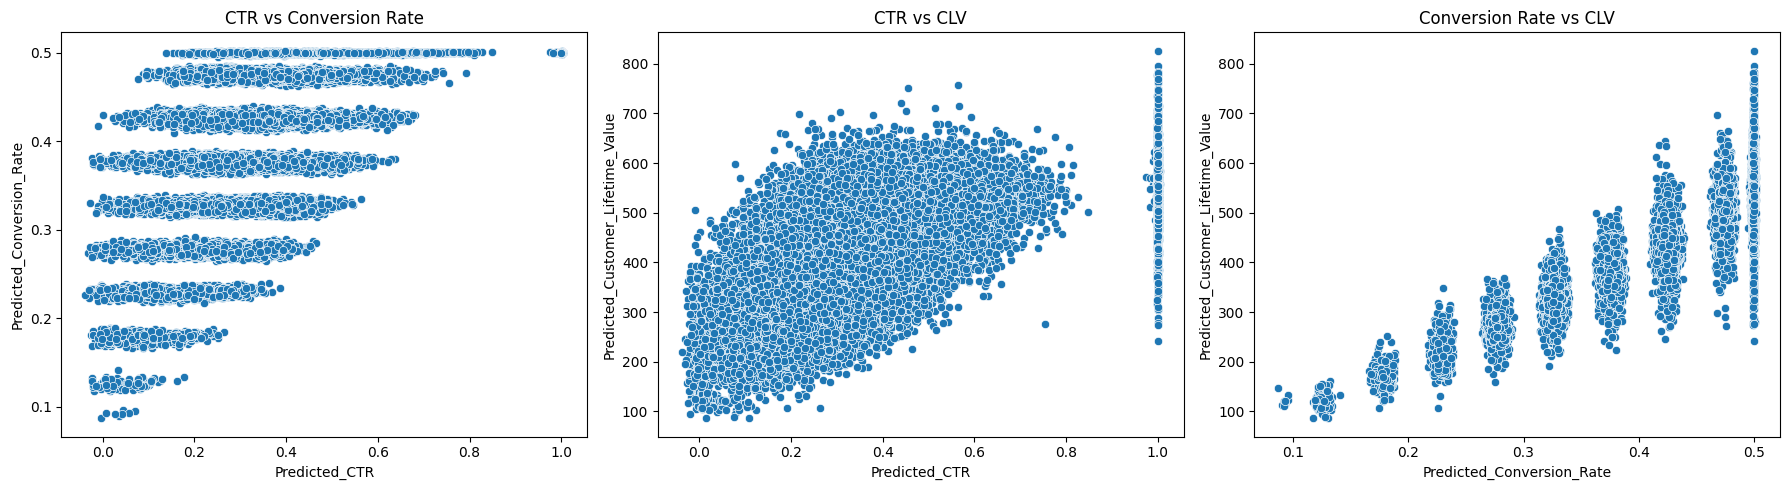

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatterplots between prediction scores
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(data=df_scaled, x='Predicted_CTR', y='Predicted_Conversion_Rate')
plt.title("CTR vs Conversion Rate")

plt.subplot(1, 3, 2)
sns.scatterplot(data=df_scaled, x='Predicted_CTR', y='Predicted_Customer_Lifetime_Value')
plt.title("CTR vs CLV")

plt.subplot(1, 3, 3)
sns.scatterplot(data=df_scaled, x='Predicted_Conversion_Rate', y='Predicted_Customer_Lifetime_Value')
plt.title("Conversion Rate vs CLV")

plt.tight_layout()
plt.show()


In [63]:
df_scaled[['Predicted_CTR', 'Predicted_Conversion_Rate', 'Predicted_Customer_Lifetime_Value']].corr()


,Predicted_CTR,Predicted_Conversion_Rate,Predicted_Customer_Lifetime_Value
Predicted_CTR,1.000000,0.641274,0.641203
Predicted_Conversion_Rate,0.641274,1.000000,0.947296
Predicted_Customer_Lifetime_Value,0.641203,0.947296,1.000000


In [67]:
# Rebuild missing categorical columns from one-hot encoding for profiling
top_ctr['Language'] = top_ctr[['Language_hi', 'Language_pt', 'Language_zh']].idxmax(axis=1).str.replace('Language_', '')
top_ctr['Location_Country'] = top_ctr[['Location_Country_China', 'Location_Country_India', 'Location_Country_UK', 'Location_Country_USA']].idxmax(axis=1).str.replace('Location_Country_', '')
top_ctr['Content_Type'] = top_ctr[['Content_Type_link', 'Content_Type_text', 'Content_Type_video']].idxmax(axis=1).str.replace('Content_Type_', '')

top_conversion['Language'] = top_conversion[['Language_hi', 'Language_pt', 'Language_zh']].idxmax(axis=1).str.replace('Language_', '')
top_conversion['Location_Country'] = top_conversion[['Location_Country_China', 'Location_Country_India', 'Location_Country_UK', 'Location_Country_USA']].idxmax(axis=1).str.replace('Location_Country_', '')
top_conversion['Content_Type'] = top_conversion[['Content_Type_link', 'Content_Type_text', 'Content_Type_video']].idxmax(axis=1).str.replace('Content_Type_', '')

top_clv['Language'] = top_clv[['Language_hi', 'Language_pt', 'Language_zh']].idxmax(axis=1).str.replace('Language_', '')
top_clv['Location_Country'] = top_clv[['Location_Country_China', 'Location_Country_India', 'Location_Country_UK', 'Location_Country_USA']].idxmax(axis=1).str.replace('Location_Country_', '')
top_clv['Content_Type'] = top_clv[['Content_Type_link', 'Content_Type_text', 'Content_Type_video']].idxmax(axis=1).str.replace('Content_Type_', '')

# Combine top users from all three models for profiling comparison
top_influencers_combined = pd.concat([top_ctr[['UserID', 'Predicted_CTR', 'Followers', 'Degree_Centrality', 'PageRank', 'Language', 'Location_Country', 'Content_Type', 'Klout_Score', 'Kred_Score']],
                                      top_conversion[['UserID', 'Predicted_Conversion_Rate', 'Followers', 'Degree_Centrality', 'PageRank', 'Language', 'Location_Country', 'Content_Type', 'Klout_Score', 'Kred_Score']],
                                      top_clv[['UserID', 'Predicted_Customer_Lifetime_Value', 'Followers', 'Degree_Centrality', 'PageRank', 'Language', 'Location_Country', 'Content_Type', 'Klout_Score', 'Kred_Score']]],
                                    keys=['Top 5 by Predicted_CTR', 'Top 5 by Predicted_Conversion_Rate', 'Top 5 by Predicted_Customer_Lifetime_Value'])

top_influencers_combined = top_influencers_combined.reset_index(drop=True)

# Display the combined profiles
import pandas as pd
top_influencers_combined


,UserID,Predicted_CTR,Followers,Degree_Centrality,PageRank,Language,Location_Country,Content_Type,Klout_Score,Kred_Score,Predicted_Conversion_Rate,Predicted_Customer_Lifetime_Value
0,41142,1.003998,3.497367,0.188820,-0.593505,zh,China,link,-1.271649,1.448256,NaN,NaN
1,43869,1.003780,2.059904,0.492623,2.126253,pt,China,text,-0.403888,0.739622,NaN,NaN
2,36926,1.003601,2.843483,0.188820,0.313004,pt,China,link,1.713449,1.321509,NaN,NaN
3,42481,1.003592,1.309538,0.796426,0.955585,hi,India,link,-0.542730,1.292702,NaN,NaN
4,37999,1.003498,1.331397,1.404032,1.010437,hi,USA,video,-0.646861,-0.510570,NaN,NaN
5,31919,NaN,-0.434379,-0.722589,-0.573186,hi,India,video,1.435765,1.719035,0.502153,NaN
6,36299,NaN,-0.446926,-0.114983,0.478472,hi,USA,link,1.539896,1.494346,0.502086,NaN
7,23934,NaN,-0.438821,-1.026392,-1.101904,hi,India,text,0.776267,-1.466938,0.502033,NaN
8,49759,NaN,-0.442306,0.796426,0.915658,hi,USA,link,1.678738,1.575004,0.502020,NaN
9,5714,NaN,-0.439650,-0.722589,-0.363072,hi,India,video,1.088661,1.621094,0.501976,NaN


In [70]:
# Rebuild missing categorical columns from one-hot encoding for profiling
df_scaled['Language'] = df_scaled[['Language_hi', 'Language_pt', 'Language_zh']].idxmax(axis=1).str.replace('Language_', '')
df_scaled['Location_Country'] = df_scaled[['Location_Country_China', 'Location_Country_India', 'Location_Country_UK', 'Location_Country_USA']].idxmax(axis=1).str.replace('Location_Country_', '')
df_scaled['Content_Type'] = df_scaled[['Content_Type_link', 'Content_Type_text', 'Content_Type_video']].idxmax(axis=1).str.replace('Content_Type_', '')

# Filter for top 10 CTR influencers
top_ctr_targeting = df_scaled[['UserID', 'Predicted_CTR', 'Followers', 'PageRank', 'Degree_Centrality', 'Content_Type', 'Language', 'Location_Country', 'Klout_Score', 'Kred_Score']].sort_values('Predicted_CTR', ascending=False).head(10)

# Optionally, apply filters based on follower count or content type
top_ctr_targeting_filtered = top_ctr_targeting[top_ctr_targeting['Followers'] > 1000]  # example filter

# Save to CSV
top_ctr_targeting_filtered.to_csv('top_10_ctr_influencers.csv', index=False)

print(" Exported top 10 CTR influencers to top_10_ctr_influencers.csv")

# Filter for top 10 Conversion Rate influencers
top_conversion_targeting = df_scaled[['UserID', 'Predicted_Conversion_Rate', 'Followers', 'PageRank', 'Degree_Centrality', 'Content_Type', 'Language', 'Location_Country', 'Klout_Score', 'Kred_Score']].sort_values('Predicted_Conversion_Rate', ascending=False).head(10)

# Filter for top 10 CLV influencers
top_clv_targeting = df_scaled[['UserID', 'Predicted_Customer_Lifetime_Value', 'Followers', 'PageRank', 'Degree_Centrality', 'Content_Type', 'Language', 'Location_Country', 'Klout_Score', 'Kred_Score']].sort_values('Predicted_Customer_Lifetime_Value', ascending=False).head(10)

# Save to CSVs
top_conversion_targeting.to_csv('top_10_conversion_influencers.csv', index=False)
top_clv_targeting.to_csv('top_10_clv_influencers.csv', index=False)

print(" Exported top 10 Conversion Rate influencers to top_10_conversion_influencers.csv")
print(" Exported top 10 CLV influencers to top_10_clv_influencers.csv")


 Exported top 10 CTR influencers to top_10_ctr_influencers.csv
 Exported top 10 Conversion Rate influencers to top_10_conversion_influencers.csv
 Exported top 10 CLV influencers to top_10_clv_influencers.csv


In [71]:
# Rebuild missing categorical columns from one-hot encoding for profiling
df_scaled['Language'] = df_scaled[['Language_hi', 'Language_pt', 'Language_zh']].idxmax(axis=1).str.replace('Language_', '')
df_scaled['Location_Country'] = df_scaled[['Location_Country_China', 'Location_Country_India', 'Location_Country_UK', 'Location_Country_USA']].idxmax(axis=1).str.replace('Location_Country_', '')
df_scaled['Content_Type'] = df_scaled[['Content_Type_link', 'Content_Type_text', 'Content_Type_video']].idxmax(axis=1).str.replace('Content_Type_', '')

# Filter for top 10 Conversion Rate influencers
top_conversion_targeting = df_scaled[['UserID', 'Predicted_Conversion_Rate', 'Followers', 'PageRank', 'Degree_Centrality', 'Content_Type', 'Language', 'Location_Country', 'Klout_Score', 'Kred_Score']].sort_values('Predicted_Conversion_Rate', ascending=False).head(10)

# Filter for top 10 CLV influencers
top_clv_targeting = df_scaled[['UserID', 'Predicted_Customer_Lifetime_Value', 'Followers', 'PageRank', 'Degree_Centrality', 'Content_Type', 'Language', 'Location_Country', 'Klout_Score', 'Kred_Score']].sort_values('Predicted_Customer_Lifetime_Value', ascending=False).head(10)

# Save to CSVs
top_conversion_targeting.to_csv('top_10_conversion_influencers.csv', index=False)
top_clv_targeting.to_csv('top_10_clv_influencers.csv', index=False)

print(" Exported top 10 Conversion Rate influencers to top_10_conversion_influencers.csv")
print(" Exported top 10 CLV influencers to top_10_clv_influencers.csv")


 Exported top 10 Conversion Rate influencers to top_10_conversion_influencers.csv
 Exported top 10 CLV influencers to top_10_clv_influencers.csv


In [72]:
# Filter high CTR influencers (for short-term campaigns)
high_ctr_influencers = df_scaled[['UserID', 'Predicted_CTR', 'Followers', 'PageRank', 'Degree_Centrality', 'Content_Type', 'Language', 'Location_Country']].sort_values('Predicted_CTR', ascending=False).head(10)

# Filter high Conversion Rate influencers (for long-term campaigns)
high_conversion_influencers = df_scaled[['UserID', 'Predicted_Conversion_Rate', 'Followers', 'PageRank', 'Degree_Centrality', 'Content_Type', 'Language', 'Location_Country']].sort_values('Predicted_Conversion_Rate', ascending=False).head(10)

# Filter high CLV influencers (for long-term campaigns)
high_clv_influencers = df_scaled[['UserID', 'Predicted_Customer_Lifetime_Value', 'Followers', 'PageRank', 'Degree_Centrality', 'Content_Type', 'Language', 'Location_Country']].sort_values('Predicted_Customer_Lifetime_Value', ascending=False).head(10)

# Combine all the influencers for optimization
all_influencers_for_optimization = pd.concat([high_ctr_influencers, high_conversion_influencers, high_clv_influencers])

# Assign Ad Budget and Ad Creative based on the type of influencer
# High CTR influencers get budget for click-generating ads (short-term)
all_influencers_for_optimization['Ad_Budget'] = 0
all_influencers_for_optimization['Ad_Budget'] = all_influencers_for_optimization['UserID'].apply(
    lambda x: 200 if x in high_ctr_influencers['UserID'].values else 0)

# High Conversion & CLV influencers get budget for long-term value ads (long-term)
all_influencers_for_optimization['Ad_Creative_Type'] = ''
all_influencers_for_optimization['Ad_Creative_Type'] = all_influencers_for_optimization['UserID'].apply(
    lambda x: 'Click-Through Ads' if x in high_ctr_influencers['UserID'].values else 'Value-Based Ads'
)

# Save to CSV for analysis
all_influencers_for_optimization.to_csv('optimized_ad_placements.csv', index=False)

print(" Exported optimized ad placements to optimized_ad_placements.csv")


 Exported optimized ad placements to optimized_ad_placements.csv


In [76]:
import numpy as np

# Function to simulate real-world data based on predictions
def simulate_performance(predicted_values, noise_factor=0.1):
    # Adding random noise (simulating real-world variance)
    noise = np.random.uniform(-noise_factor, noise_factor, len(predicted_values))
    simulated_values = predicted_values * (1 + noise)
    return simulated_values

# Simulate performance data based on predicted values
performance_comparison = df_scaled[['UserID', 'Predicted_CTR', 'Predicted_Conversion_Rate', 'Predicted_Customer_Lifetime_Value']].copy()

# Simulate actual CTR, Conversion Rate, and CLV with random noise
performance_comparison['Actual_CTR'] = simulate_performance(performance_comparison['Predicted_CTR'], noise_factor=0.1)
performance_comparison['Actual_Conversion_Rate'] = simulate_performance(performance_comparison['Predicted_Conversion_Rate'], noise_factor=0.2)
performance_comparison['Actual_CLV'] = simulate_performance(performance_comparison['Predicted_Customer_Lifetime_Value'], noise_factor=0.2)

# Compare performance (predicted vs. actual)
performance_comparison['CTR_Performance'] = performance_comparison['Actual_CTR'] / performance_comparison['Predicted_CTR']
performance_comparison['Conversion_Rate_Performance'] = performance_comparison['Actual_Conversion_Rate'] / performance_comparison['Predicted_Conversion_Rate']
performance_comparison['CLV_Performance'] = performance_comparison['Actual_CLV'] / performance_comparison['Predicted_Customer_Lifetime_Value']

# Optionally, flag underperforming influencers
performance_comparison['Underperforming'] = performance_comparison[['CTR_Performance', 'Conversion_Rate_Performance', 'CLV_Performance']].apply(
    lambda row: 'Yes' if any(x < 0.8 for x in row) else 'No', axis=1
)

# Save the simulated performance data
performance_comparison.to_csv('performance_comparison.csv', index=False)

print(" performance data saved to 'performance_comparison.csv'")


 performance data saved to 'performance_comparison.csv'


In [78]:
import numpy as np
import pandas as pd

# Simulate campaign performance based on predicted data
def simulate_performance(predicted_values, noise_factor=0.1):
    # Adding random noise (simulating real-world variance)
    noise = np.random.uniform(-noise_factor, noise_factor, len(predicted_values))
    simulated_values = predicted_values * (1 + noise)
    return simulated_values

# Assuming df_scaled contains the predicted data
# Simulate actual CTR, Conversion Rate, and CLV based on predicted values
performance_data = df_scaled[['UserID', 'Predicted_CTR', 'Predicted_Conversion_Rate', 'Predicted_Customer_Lifetime_Value']].copy()

# Simulate actual CTR, Conversion Rate, and CLV with random noise
performance_data['Actual_CTR'] = simulate_performance(performance_data['Predicted_CTR'], noise_factor=0.1)
performance_data['Actual_Conversion_Rate'] = simulate_performance(performance_data['Predicted_Conversion_Rate'], noise_factor=0.15)
performance_data['Actual_CLV'] = simulate_performance(performance_data['Predicted_Customer_Lifetime_Value'], noise_factor=0.2)

# Compare performance (predicted vs. actual)
performance_data['CTR_Error'] = performance_data['Actual_CTR'] - performance_data['Predicted_CTR']
performance_data['Conversion_Error'] = performance_data['Actual_Conversion_Rate'] - performance_data['Predicted_Conversion_Rate']
performance_data['CLV_Error'] = performance_data['Actual_CLV'] - performance_data['Predicted_Customer_Lifetime_Value']

# Calculate error metrics (e.g., RMSE for each prediction)
rmse_ctr = np.sqrt(((performance_data['Actual_CTR'] - performance_data['Predicted_CTR'])**2).mean())
rmse_conversion = np.sqrt(((performance_data['Actual_Conversion_Rate'] - performance_data['Predicted_Conversion_Rate'])**2).mean())
rmse_clv = np.sqrt(((performance_data['Actual_CLV'] - performance_data['Predicted_Customer_Lifetime_Value'])**2).mean())

# Print the RMSE for each metric
print(f"RMSE for CTR Prediction: {rmse_ctr}")
print(f"RMSE for Conversion Rate Prediction: {rmse_conversion}")
print(f"RMSE for CLV Prediction: {rmse_clv}")

# Identify underperforming influencers (e.g., those whose actual performance is lower than 80% of the predicted value)
underperforming_influencers = performance_data[
    (performance_data['CTR_Error'] < -0.2) | 
    (performance_data['Conversion_Error'] < -0.2) | 
    (performance_data['CLV_Error'] < -0.2)
]

# Save the underperforming influencers for review
underperforming_influencers.to_csv('simulated_underperforming_influencers.csv', index=False)

# Optionally, create a new model using the feedback from underperforming influencers (e.g., retrain with new data)
# This is a simplified step to indicate that after analyzing underperformers, you can retrain your models
# retrained_model = XGBRegressor().fit(new_training_data, target_variable)
# export_model(retrained_model)

# Save the complete simulated performance comparison to a CSV
performance_data.to_csv('simulated_performance_comparison.csv', index=False)

print(" Simulated performance data saved to 'simulated_performance_comparison.csv'")


RMSE for CTR Prediction: 0.03208530107660087
RMSE for Conversion Rate Prediction: 0.037643409832736834
RMSE for CLV Prediction: 53.26910187505109
 Simulated performance data saved to 'simulated_performance_comparison.csv'


<Figure size 1400x800 with 0 Axes>

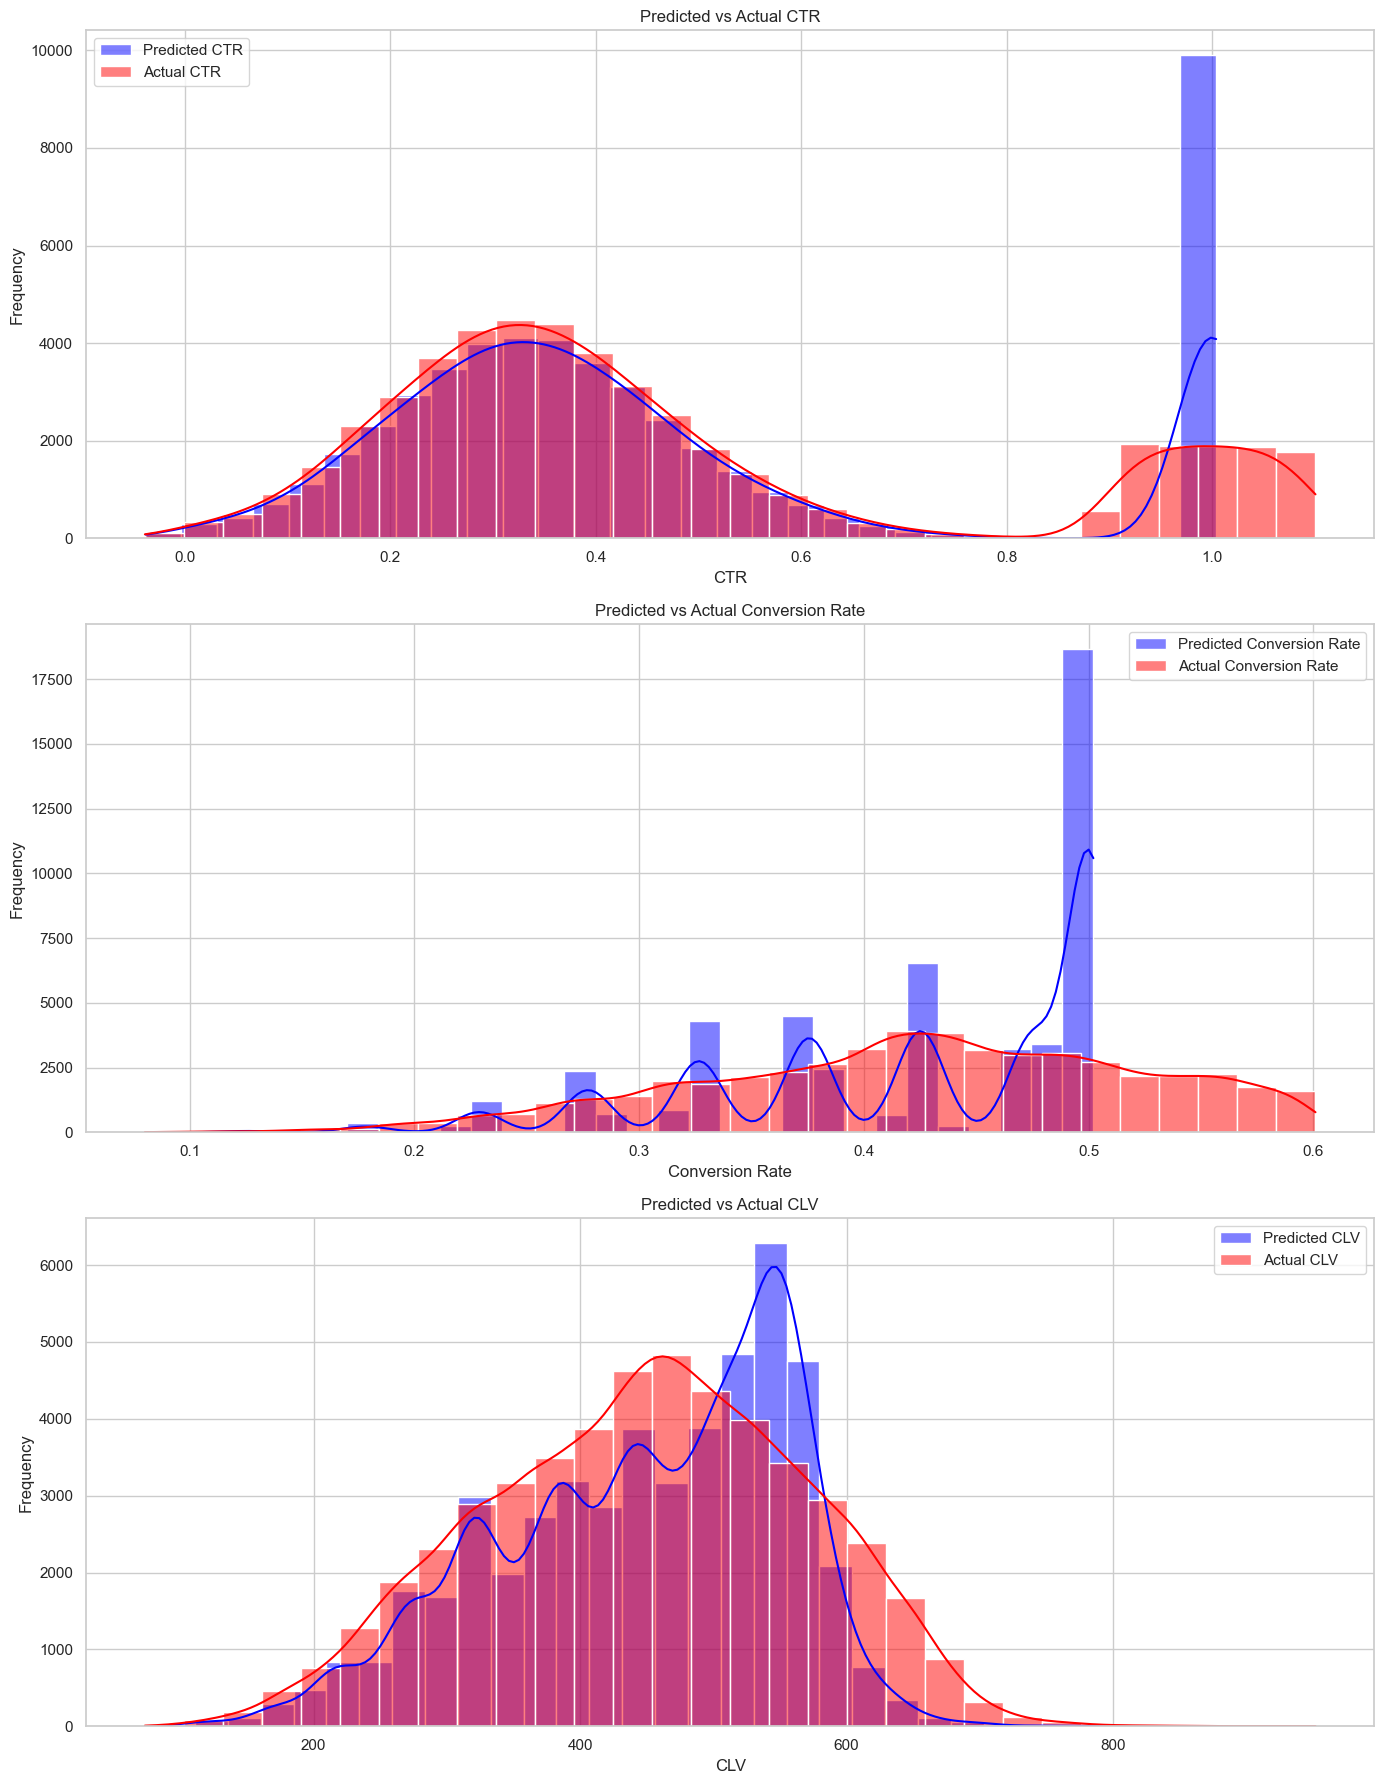

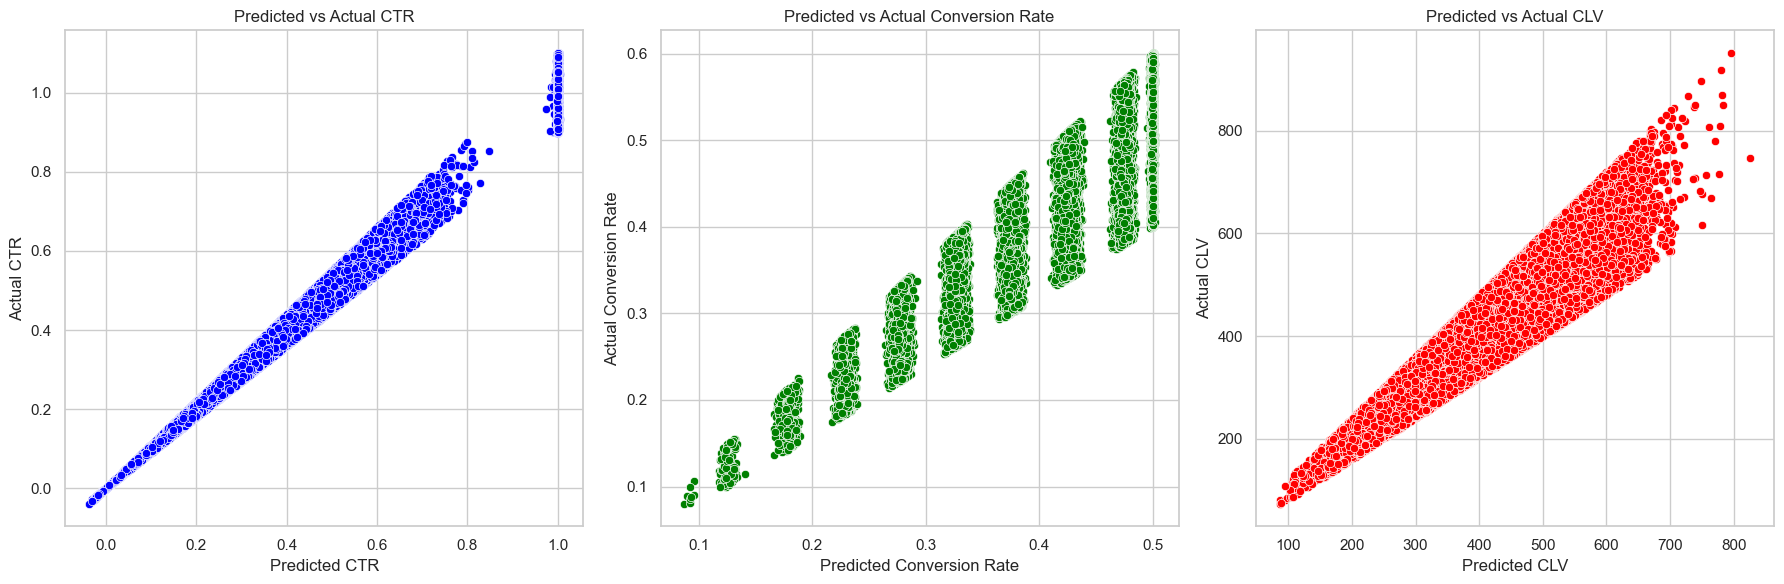

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV files using the correct file paths
performance_comparison = pd.read_csv('performance_comparison.csv')

# Set up the visualization style
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))

# Plot comparison of Predicted vs Actual for CTR, Conversion Rate, and CLV
fig, axs = plt.subplots(3, 1, figsize=(14, 18))

# CTR comparison
sns.histplot(performance_comparison['Predicted_CTR'], color='blue', kde=True, label='Predicted CTR', ax=axs[0], bins=30)
sns.histplot(performance_comparison['Actual_CTR'], color='red', kde=True, label='Actual CTR', ax=axs[0], bins=30)
axs[0].set_title('Predicted vs Actual CTR')
axs[0].set_xlabel('CTR')
axs[0].set_ylabel('Frequency')
axs[0].legend()

# Conversion Rate comparison
sns.histplot(performance_comparison['Predicted_Conversion_Rate'], color='blue', kde=True, label='Predicted Conversion Rate', ax=axs[1], bins=30)
sns.histplot(performance_comparison['Actual_Conversion_Rate'], color='red', kde=True, label='Actual Conversion Rate', ax=axs[1], bins=30)
axs[1].set_title('Predicted vs Actual Conversion Rate')
axs[1].set_xlabel('Conversion Rate')
axs[1].set_ylabel('Frequency')
axs[1].legend()

# CLV comparison
sns.histplot(performance_comparison['Predicted_Customer_Lifetime_Value'], color='blue', kde=True, label='Predicted CLV', ax=axs[2], bins=30)
sns.histplot(performance_comparison['Actual_CLV'], color='red', kde=True, label='Actual CLV', ax=axs[2], bins=30)
axs[2].set_title('Predicted vs Actual CLV')
axs[2].set_xlabel('CLV')
axs[2].set_ylabel('Frequency')
axs[2].legend()

plt.tight_layout()
plt.show()

# Optional: Scatter plots to compare actual vs predicted for each metric
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot for CTR
sns.scatterplot(x=performance_comparison['Predicted_CTR'], y=performance_comparison['Actual_CTR'], ax=axs[0], color='blue')
axs[0].set_title('Predicted vs Actual CTR')
axs[0].set_xlabel('Predicted CTR')
axs[0].set_ylabel('Actual CTR')

# Scatter plot for Conversion Rate
sns.scatterplot(x=performance_comparison['Predicted_Conversion_Rate'], y=performance_comparison['Actual_Conversion_Rate'], ax=axs[1], color='green')
axs[1].set_title('Predicted vs Actual Conversion Rate')
axs[1].set_xlabel('Predicted Conversion Rate')
axs[1].set_ylabel('Actual Conversion Rate')

# Scatter plot for CLV
sns.scatterplot(x=performance_comparison['Predicted_Customer_Lifetime_Value'], y=performance_comparison['Actual_CLV'], ax=axs[2], color='red')
axs[2].set_title('Predicted vs Actual CLV')
axs[2].set_xlabel('Predicted CLV')
axs[2].set_ylabel('Actual CLV')

plt.tight_layout()
plt.show()
